In [49]:
from nnsight import NNsight
import torch 
from transformers import GPTJForCausalLM, AutoTokenizer 
from IPython.display import clear_output
from nnsight import LanguageModel
from typing import List, Callable
import torch
import numpy as np
from IPython.display import clear_output
import seaborn as sns
import matplotlib.pyplot as plt
 
model_path = "/data/lmm/checkpoints/checkpoint-1953"
gptj = GPTJForCausalLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = LanguageModel(gptj,tokenizer=tokenizer)

In [100]:
model = LanguageModel(gptj,tokenizer=tokenizer)


prompt= """| deer | cat | bird |
| deer | cat | cat |
| bird | dog | bird |
The grid above is size 3 by 3. Each cell contains an object from ['deer', 'bird', 'dog', 'cat'].
What object is in row 0, column 0? A: 
"""

layers = model.transformer.h
probs_layers = []

with model.trace() as tracer:
    with tracer.invoke(prompt) as invoker:
        for layer_idx, layer in enumerate(layers):
            # Process layer output through the model's head and layer normalization
            layer_output = model.lm_head(model.transformer.ln_f(layer.output[0]))

            # Apply softmax to obtain probabilities and save the result
            probs = torch.nn.functional.softmax(layer_output, dim=-1).save()
            probs_layers.append(probs)

probs = torch.cat([probs.value for probs in probs_layers])

# Find the maximum probability and corresponding tokens for each position
max_probs, tokens = probs.max(dim=-1)

# Decode token IDs to words for each layer
words = [[model.tokenizer.decode(t.cpu()).encode("unicode_escape").decode() for t in layer_tokens]
    for layer_tokens in tokens]

# Access the 'input_ids' attribute of the invoker object to get the input words
input_words = [model.tokenizer.decode(t) for t in invoker.inputs[0]["input_ids"][0]]



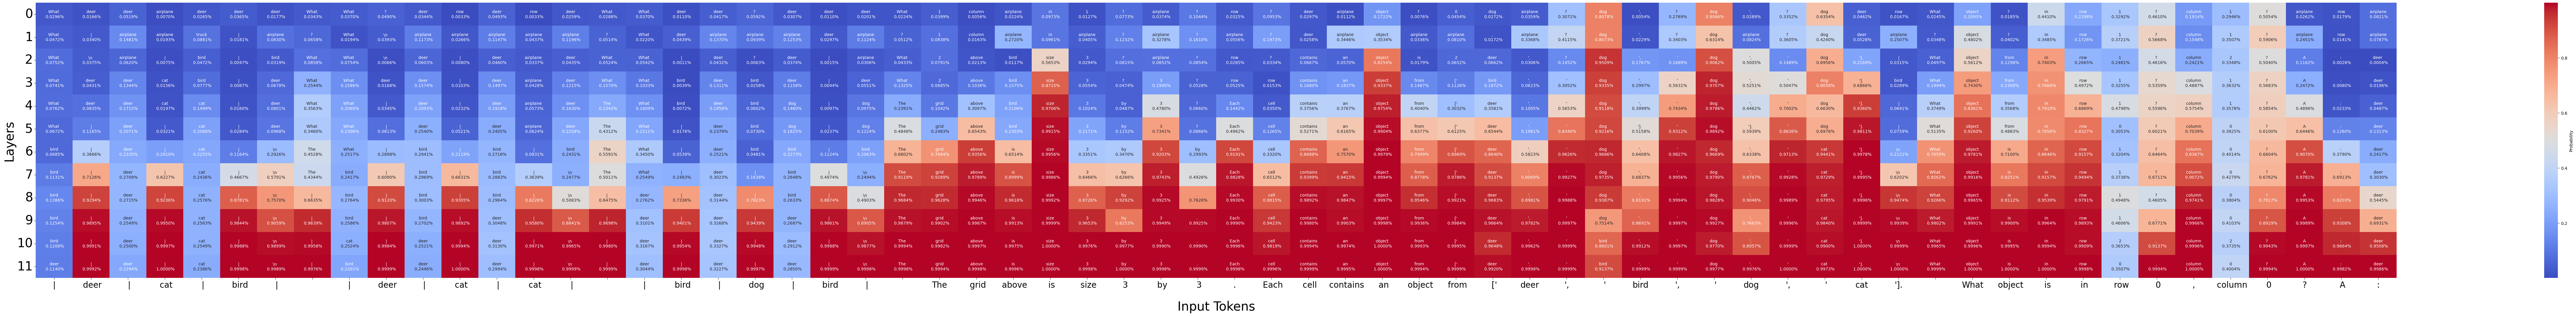

In [101]:
data = max_probs.detach().numpy()[:, :64]  
cutoff = [layer[:64] for layer in words]  

annotations = []
for layer_idx, layer_words in enumerate(cutoff):  
    annotation_layer = []
    for token_idx, word in enumerate(layer_words): 
        prob = data[layer_idx, token_idx]
        annotation_layer.append(f"{word} \n {prob:.4f}%")
    annotations.append(annotation_layer)  

plt.figure(figsize=(128, 12))  

ax = sns.heatmap(data, 
                 annot=annotations,            
                 fmt='s',                       
                 cmap='coolwarm',               
                 annot_kws={"size": 10},        
                 cbar_kws={'label': 'Probability'},  
                 cbar=True,                     
                 )


plt.xlabel("Input Tokens", fontsize=30)  
plt.ylabel("Layers", fontsize=30)  

ax.set_xticks([x + 0.5 for x in range(len(input_words[:64]))])  
ax.set_xticklabels(input_words[:64], fontsize=20, ha='center')  

plt.yticks(rotation=0, fontsize=30)  

plt.savefig("logit_lens_plot.png", dpi=300, bbox_inches='tight')
plt.show()
